## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

In [1]:
! pip install timm

In [2]:
import torch, torchvision, time, os, copy, random, imageio, os, shutil,timm
import torch.nn as nn, matplotlib.pyplot as plt, seaborn as sn, pandas as pd
import torch.optim as optim, numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix

folderlocation = './data/'
if not os.path.exists(folderlocation):
    os.mkdir(folderlocation)
folderlocation = './data/STL10/'
if not os.path.exists(folderlocation):
    os.mkdir(folderlocation)
path = folderlocation
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'train/'
if not os.path.exists(path):
    os.mkdir(path)
        
path = folderlocation + 'valid/'
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'test/'
if not os.path.exists(path):
    os.mkdir(path)
    
for iter1 in range(10):    # 10 = number of classes
    path = folderlocation + 'train/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    path = folderlocation + 'valid/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    
    path = folderlocation + 'test/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)

        
data_train = torchvision.datasets.STL10('/files/', split='train', download=True,
                             transform=torchvision.transforms.Compose([]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    if iter1%10 ==0:
        imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    else:
        imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x)
    
data_test = torchvision.datasets.STL10('/files/', split='test', download=True,
                             transform=torchvision.transforms.Compose([]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)



100%|██████████| 2640397119/2640397119 [00:23<00:00, 113576866.22it/s]


Extracting /files/stl10_binary.tar.gz to /files/
Files already downloaded and verified


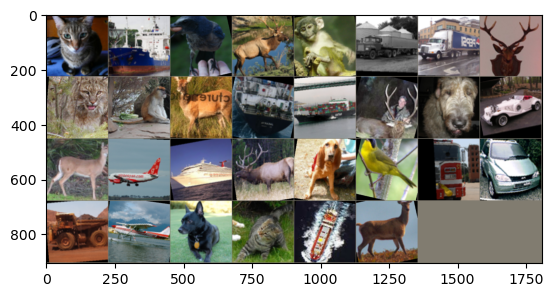

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
im_dimention =224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None): 
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.507, 0.487, 0.441])
    std = np.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#import matplotlib.pyplot as plt
#plt.rcParams["figure.dpi"] = 200

#plt.savefig('Transformed.pdf')  

imshow(out)#, title=[class_names[x] for x in classes])

In [4]:
Num_class=10

model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
num_ftrs = model_ft.head.in_features



# Customizable SpinalNet. Supports up to 30 layers.
class SpinalNet(nn.Module):
    def __init__(self, Input_Size, Number_of_Split, HL_width, number_HL, Output_Size, Activation_Function):
        
        super(SpinalNet, self).__init__()
        Splitted_Input_Size = int(np.round(Input_Size/Number_of_Split))
        self.lru = Activation_Function
        self.fc1 = nn.Linear(Splitted_Input_Size, HL_width)
        if number_HL>1:
            self.fc2 = nn.Linear(Splitted_Input_Size+HL_width, HL_width)
        
        
        self.fcx = nn.Linear(HL_width*number_HL, Output_Size)

    def forward(self, x):
        x_all =x        
        
        Splitted_Input_Size = self.fc1.in_features
        HL_width = self.fc2.in_features - self.fc1.in_features
        number_HL = int(np.round(self.fcx.in_features/HL_width))
        length_x_all = number_HL*Splitted_Input_Size      
        
        while x_all.size(dim=1) < length_x_all:
            x_all = torch.cat([x_all, x],dim=1)
            
        x = self.lru(self.fc1(x_all[:,0:Splitted_Input_Size]))
        x_out = x
        
        for counter1 in range(1, number_HL):

            if number_HL>counter1:
                x_from_all = x_all[:,Splitted_Input_Size* counter1:Splitted_Input_Size*(counter1+1)]
                x = self.lru(self.fc2(torch.cat([x_from_all, x], dim=1)))
                x_out = torch.cat([x_out, x], dim=1)
        x = self.fcx(x_out)
        return x

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
'''
Changing the fully connected layer to SpinalNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.head = SpinalNet(Input_Size = num_ftrs, Number_of_Split =8, HL_width=20, number_HL=8, Output_Size=Num_class, Activation_Function = nn.ReLU(inplace=True))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

In [7]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.4870 Acc: 0.8922
valid Loss: 0.0356 Acc: 0.9980
test Loss: 0.0397 Acc: 0.9964

Epoch 1/1
----------
train Loss: 0.0210 Acc: 0.9973
valid Loss: 0.0198 Acc: 0.9960

Training complete in 12m 52s
Best val Acc: 0.998000


## Confusion Matrix

Test Accuracy: 0.996375


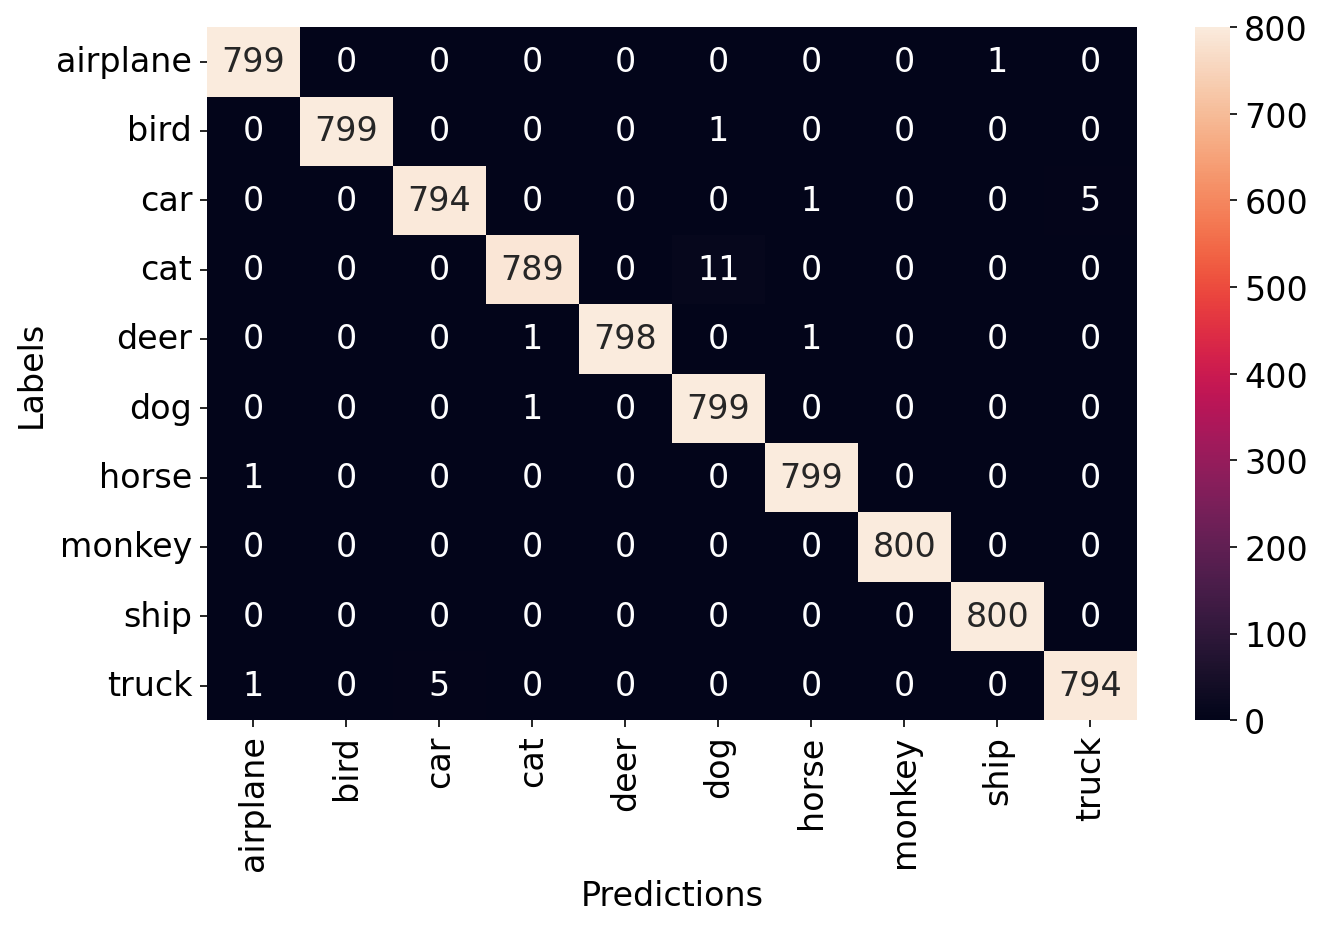

In [8]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

        
# constant for classes
classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (10,6),dpi=150)
plt.rcParams['font.size'] = '16'
fig = sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show(fig)

fig.figure.savefig('Confusion_test.pdf', bbox_inches = 'tight') 

# Delete Downloaded Data

In [9]:
shutil.rmtree('./data/')